In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from geoid.censusnames import stusab

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

from shapely.geometry import Point


In [2]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import rowgenerators as rg
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import box
import metapack as mp
import seaborn as sns
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

from demosearch import *
from demosearch.install import *
from demosearch.raster import *
from demosearch.plot import * 
from demosearch.geocode import * 

import libgeohash as gh

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

cache_dir = '/Volumes/SSD_Extern/radius'
cache = FileCache(cache_dir)


In [3]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# Starbucks Locations
`chrismeller.github.com-starbucks-1.1.2` Last Update: 2021-02-24T19:00:15

_A list of Starbucks locations, scraped from the web in 2017_


Starbucks locations scraped from the Starbucks website by Chris Meller. From the original README: 


    Contains a single commit for each day that batches up all changes to 
    the Starbucks dataset as a CSV file.

    Deletes will obviously be stores that seem to have closed and adds 
    are new stores that have opened.

    This is a work in progress. There is additional data that needs 
    to be included in this dataset and it needs to get properly automated 
    so we hav e a regular commit daily at a particular time.
## Documentation Links

* [Source](https://github.com/chrismeller/StarbucksLocations) Github page for the datafile source

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [all_starbucks](https://github.com/chrismeller/StarbucksLocations/raw/master/stores.csv)**. List of Starbucks locations.
* ** [us_starbucks](notebooks/convert.ipynb#ussb)**. Geo file of starbucks in the US

## References
<ul><li> <strong>states</string>, <em>censusgeo://2019/5/US/state</em>. US States</li><ul>

In [4]:
df = pkg.resource('all_starbucks').dataframe().dropna(subset=['Longitude','Latitude'])

/Users/eric/proj/code-projects/radius-search/demosearch/venv/lib/python3.7/site-packages/metapack/terms.py:698: UserWarning: Failed to set parse dates . Trying again without parse_dates configuration
  warnings.warn('Failed to set parse dates . Trying again without parse_dates configuration')


In [5]:
states = pkg.reference('states').geoframe().to_crs(4326)[['geoid','geometry']]

In [6]:
df['geometry'] = df.apply(lambda r: Point(r.Longitude, r.Latitude), axis=1)
df = gpd.GeoDataFrame(df, crs=4326)
ussb = gpd.overlay(df, states) # Starbucks in the US

<AxesSubplot:>

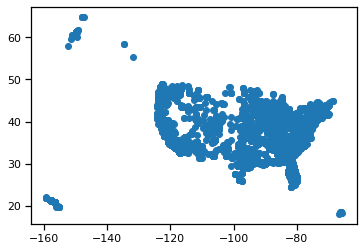

In [7]:
ussb.plot()

In [8]:
len(ussb)

13631

In [14]:
from time import sleep



gc.geocoders

[(<bound method CachingGeocoder.gc_mapquest of <demosearch.geocode.CachingGeocoder object at 0x16a67fd10>>,
  'mapquest',
  'ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59')]

In [27]:
gc = CachingGeocoder(cache, open_cage=False, mapbox=False)

t = list(ussb.iterrows())
rows = []
for idx, r in tqdm(t):
    addr = f'{r.Street1} {r.City}, {r.CountrySubdivisionCode} {str(r.PostalCode)[:5]}' 
    g = gc.geocode(addr)
    try:
        rows.append( (r.Id, g['_geocoder'], g['_cache'], g['lat'], g['lng']))
    except:
        break
   
    if g['_cache'] == 'miss':
        sleep(.5)

#df = pd.DataFrame(rows, columns='id geocoder cache lat lon'.split())
#df.head()

 90%|█████████ | 12307/13631 [00:02<00:00, 5125.92it/s]

exit 110 Westbound, milepost 112.3; 179 Somerset, PA 15501 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


 91%|█████████ | 12427/13631 [00:03<00:00, 2796.07it/s]

7 Wood Street Pittsburgh, PA 15222 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


 91%|█████████ | 12428/13631 [00:03<00:00, 1903.10it/s]

112 Washington Pl Pittsburgh, PA 15219 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


 91%|█████████ | 12429/13631 [00:04<00:00, 1399.89it/s]

1398 Columbia Ave Lancaster, PA 17603 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


 91%|█████████ | 12430/13631 [00:05<00:01, 1094.08it/s]

312 Woodland Rd Mount Pocono, PA 18344 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


 91%|█████████ | 12431/13631 [00:05<00:01, 875.47it/s] 

1400 East Carson Street Pittsburgh, PA 15203 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


 91%|█████████ | 12432/13631 [00:06<00:01, 718.74it/s]

57-63 North Third Street Philadelphia, PA 19106 ZGku7J6SaZxRPWRxbGx2Ignrbw1I2Z59


KeyboardInterrupt: 

In [23]:
len(df), df.geocoder.value_counts()

(13631,
 mapquest     5563
 mapbox       4215
 open_cage    3853
 Name: geocoder, dtype: int64)

In [ ]:
s = [Point(r.lon, r.lat) for idx, r in df.iterrows()]
gdf = gpd.GeoDataFrame({'geometry':s}, crs=4326)

In [ ]:
gdf.to_csv('sbux.csv')

In [24]:
df.tail()

,id,geocoder,cache,lat,lon
13626,78d355f7-5c7a-44b0-b7ee-667d6266019b,mapquest,miss,42.900071,-73.210846
13627,2047aa73-0446-47e0-a906-b87f537acfe5,mapquest,miss,44.477289,-73.216741
13628,c419cd9e-9bd2-46e2-843a-cff19a94ebe5,mapquest,miss,44.446667,-73.110238
13629,38e89d15-d0b5-4b49-a74b-ef64e332a4b3,mapquest,miss,44.223452,-72.547273
13630,653a0286-4f9f-4f47-8702-fd1e7d4d4d24,mapquest,miss,43.173957,-73.050682


In [28]:
t = df.drop(columns='cache')